# Ejemplo OVFCA

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from scipy.stats import ortho_group

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

In [3]:
from BSS import Mezcla_imagenes, OVFCA, FCA, FCA_no_centrado, OVFCA_no_centrado
from Independence import Free_Independence, OV_Independence

In [4]:
# definir variables importantes

# las matrices seran de tamaño NM x NM
N = 100

# valores de M_i para futuros calculos
M_1 = 200
M_2 = 100
M_3 = 40
M_4 = 25

In [5]:
# definir las esperanzas condicionales F1, F2 : matrices nxn -> matrices nxn  (donde n = NM)

# F1: matrices N x N -> matrices N x N
# la definicion de la tesis esta medio rara
# la ajusto un poco, segun yo asi hace mas sentido
def esperanza_condicional_F1(A):
    return 1/(N) * A.trace() * np.eye(N)

# F1: matrices 2N x 2N -> matrices 2N x 2N
# la definicion de la tesis esta medio rara
# la ajusto un poco, segun yo asi hace mas sentido
def esperanza_condicional_F1(A):
    return 1/(2*N) * A.trace() * np.eye(2*N)

# -----

# F2: matrices 2N x 2N -> matrices 2N x 2N
def esperanza_condicional_F2(A):
    assert A.shape == (2*N, 2*N)
    # sacar los 4 bloques de NxN
    A11 = A[0:N, 0:N]
    A12 = A[0:N, N:2*N]
    A21 = A[N:2*N, 0:N]
    A22 = A[N:2*N, N:2*N]
    # calcular los 4 bloques del resultado
    B11 = 1/N * A11.trace() * np.eye(N)
    B12 = 1/N * A12.trace() * np.eye(N)
    B21 = 1/N * A21.trace() * np.eye(N)
    B22 = 1/N * A22.trace() * np.eye(N)
    # juntar para crear el resultado
    return np.block([[B11, B12], [B21, B22]])

# ---

# considerar la norma de frobenius en la imagen de la esperanza condicional
def frobenius_norm(A):
    assert A.shape == (2*N, 2*N)
    return np.linalg.norm(A, 'fro')

In [6]:
# Hacer 4 matrices F_i de tamaños N x M_i
F_1 = np.random.randn(N, M_1)
F_2 = np.random.randn(N, M_2)
F_3 = np.random.randn(N, M_3)
F_4 = np.random.randn(N, M_4)

In [7]:
# hacer 4 matrices S_i de tamaños N x N
S_1 = (1/M_1) * F_1 @ F_1.T
S_2 = (1/M_2) * F_2 @ F_2.T
S_3 = (1/M_3) * F_3 @ F_3.T
S_4 = (1/M_4) * F_4 @ F_4.T

In [8]:
# matrices de utilidad D1, D2 de tamaño 2x2
D_1 = np.array([[1, 0], [0, 1]])
D_2 = np.array([[0, 1], [1, 0]])

In [9]:
# hacer las señales originales A1, A2 de tamaños 2N x 2N
A1 = np.kron(D_1, S_1) + np.kron(D_2, S_3)
A2 = np.kron(D_1, S_2) + np.kron(D_2, S_4)

# juntar las señales 
señales_originales = [A1, A2]

## Comprobar suposiciones de las matrices

$$
A_1 = \begin{pmatrix}
     S_1 & S_3 \\
     S_3 & S_1
     \end{pmatrix}
\quad
\quad
\quad
A_2 = \begin{pmatrix}
     S_2 & S_4 \\
     S_4 & S_2
     \end{pmatrix}
$$


Las matrices $S_i$ segun yo son Wishart matrices
(sus eigenvalores converguen a Marchenko-Pastur distribution)

In [10]:
# funcional sobre los elementos de las matrices (que son matrices N x N)
def phi(a):
    assert a.shape == (N, N)
    return 1/(N) * a.trace()

In [11]:
# funcional: psi = tr tensor phi
def funcional_psi(A):
    assert A.shape == (2*N, 2*N)
    
    # sacar los 2 bloques de NxN de la diagonal
    A11 = A[0:N, 0:N]
    A22 = A[N:2*N, N:2*N]
    # aplicarles phi
    B11 = phi(A11)
    B22 = phi(A22)
    # devolver la traza 
    return 1/2 * (B11 + B22)

In [12]:
# ver los primeros momentos de las variables S, i.e  phi(S)
print(Free_Independence(S_1, None, phi, product = lambda x, y: x@y).evaluate_cumulant(("A",)))
print(Free_Independence(S_2, None, phi, product = lambda x, y: x@y).evaluate_cumulant(("A",)))
print(Free_Independence(S_3, None, phi, product = lambda x, y: x@y).evaluate_cumulant(("A",)))
print(Free_Independence(S_4, None, phi, product = lambda x, y: x@y).evaluate_cumulant(("A",)))

0.9795612678042553
1.0037231404323184
1.0144767621826827
0.9707413997340207


In [13]:
# ahroa ver phi(S^2) - phi(S) ^ 2
print(Free_Independence(S_1, None, phi, product = lambda x, y: x@y).evaluate_cumulant(("A", "A")))
print(Free_Independence(S_2, None, phi, product = lambda x, y: x@y).evaluate_cumulant(("A", "A")))
print(Free_Independence(S_3, None, phi, product = lambda x, y: x@y).evaluate_cumulant(("A", "A")))
print(Free_Independence(S_4, None, phi, product = lambda x, y: x@y).evaluate_cumulant(("A", "A")))

0.4958354951668442
1.0167143369223157
2.59835242630593
3.7732437401495447


**Ver que las entradas de las matrices, $\{S_1, S_3\}$ y $\{S_2, S_4\}$, sean libres**

In [14]:
# S1 y S2
test = Free_Independence(S_1, S_2, phi, product = lambda x, y: x@y)
_ = test.check_mixed_cumulants(max_order = 4, print_results = True)

κ(('A', 'B')) = 0.01621688001662236
κ(('A', 'A', 'B')) = -0.007087424565196454
κ(('A', 'B', 'B')) = 0.02386096004688598
κ(('A', 'A', 'A', 'B')) = -0.015173222135633546
κ(('A', 'A', 'B', 'B')) = -0.013109137313239635
κ(('A', 'B', 'A', 'B')) = -0.000311611685183095
κ(('A', 'B', 'B', 'B')) = 0.04570878193843461


In [15]:
# S1 y S4
test = Free_Independence(S_1, S_4, phi, product = lambda x, y: x@y)
_ = test.check_mixed_cumulants(max_order = 4, print_results = True)

κ(('A', 'B')) = -0.009848329076402318
κ(('A', 'A', 'B')) = -0.0006164765614126155
κ(('A', 'B', 'B')) = -0.01370002212124649
κ(('A', 'A', 'A', 'B')) = 0.019839183305302155
κ(('A', 'A', 'B', 'B')) = 0.02092936591764965
κ(('A', 'B', 'A', 'B')) = -0.017346601383580847
κ(('A', 'B', 'B', 'B')) = 0.08253288413433019


In [16]:
# S3 y S2
test = Free_Independence(S_3, S_2, phi, product = lambda x, y: x@y)
_ = test.check_mixed_cumulants(max_order = 4, print_results = True)

κ(('A', 'B')) = 0.0024305037771163995
κ(('A', 'A', 'B')) = -0.0657584097832693
κ(('A', 'B', 'B')) = 0.009482600772087402
κ(('A', 'A', 'A', 'B')) = -0.30201088055357594
κ(('A', 'A', 'B', 'B')) = -0.09456594229129062
κ(('A', 'B', 'A', 'B')) = 0.008501751402218434
κ(('A', 'B', 'B', 'B')) = 0.03333367257493032


In [17]:
# S3 y S4
test = Free_Independence(S_3, S_4, phi, product = lambda x, y: x@y)
_ = test.check_mixed_cumulants(max_order = 4, print_results = True)

κ(('A', 'B')) = 0.028504502437604606
κ(('A', 'A', 'B')) = 0.09461070173272423
κ(('A', 'B', 'B')) = 0.17797149293508174
κ(('A', 'A', 'A', 'B')) = 0.12888384455886204
κ(('A', 'A', 'B', 'B')) = 0.5900597018656248
κ(('A', 'B', 'A', 'B')) = -0.15656776783103465
κ(('A', 'B', 'B', 'B')) = 0.7248772541273598


Parecen cercanos a 0


**Ver que las matrices no son libres en el sentido escalar**


In [18]:
# A1 y A2
test = Free_Independence(A1, A2, funcional_psi, product = lambda x, y: x@y)
_ = test.check_mixed_cumulants(max_order = 4, print_results = True)

κ(('A', 'B')) = 1.0295159745730817
κ(('A', 'A', 'B')) = -0.16693198878778137
κ(('A', 'B', 'B')) = -0.010806279948119002
κ(('A', 'A', 'A', 'B')) = 9.003546003616703
κ(('A', 'A', 'B', 'B')) = 0.17370036569234387
κ(('A', 'B', 'A', 'B')) = 7.315556044699146
κ(('A', 'B', 'B', 'B')) = 19.902010513892776


**Ver que las matrices si son libres bajo la esperanza condicional**


In [19]:
# poner en formato correcto
A1_dict = {(1, 1): S_1, (1, 2): S_3, (2, 1): S_3, (2, 2): S_1}
A2_dict = {(1, 1): S_2, (1, 2): S_4, (2, 1): S_4, (2, 2): S_2}

# A1 y A2
ov_test = OV_Independence(A1_dict, A2_dict, 2, phi, product = lambda x, y: x@y)
res = ov_test.check_mixed_cumulants(max_order = 4, print_results = True)

κ^(B)(('A', 'B')) = 
[[ 0.04472138 -0.00741783]
 [-0.00741783  0.04472138]]
--
κ^(B)(('B', 'A')) = 
[[ 0.04472138 -0.00741783]
 [-0.00741783  0.04472138]]
--
κ^(B)(('A', 'A', 'B')) = 
[[-0.12190854  0.10687609]
 [ 0.10687609 -0.12190854]]
--
κ^(B)(('A', 'B', 'A')) = 
[[-0.12190854  0.10687609]
 [ 0.10687609 -0.12190854]]
--
κ^(B)(('A', 'B', 'B')) = 
[[0.04591899 0.18408359]
 [0.18408359 0.04591899]]
--
κ^(B)(('B', 'A', 'A')) = 
[[-0.12190854  0.10687609]
 [ 0.10687609 -0.12190854]]
--
κ^(B)(('B', 'A', 'B')) = 
[[0.04591899 0.18408359]
 [0.18408359 0.04591899]]
--
κ^(B)(('B', 'B', 'A')) = 
[[0.04591899 0.18408359]
 [0.18408359 0.04591899]]
--
κ^(B)(('A', 'A', 'A', 'B')) = 
[[ 0.16430979 -0.27010592]
 [-0.27010592  0.16430979]]
--
κ^(B)(('A', 'A', 'B', 'A')) = 
[[ 0.16430979 -0.27010592]
 [-0.27010592  0.16430979]]
--
κ^(B)(('A', 'A', 'B', 'B')) = 
[[ 0.4730997  -0.30512502]
 [-0.30512502  0.4730997 ]]
--
κ^(B)(('A', 'B', 'A', 'A')) = 
[[ 0.16430979 -0.27010592]
 [-0.27010592  0.16430979

## Mezclar

In [20]:
# funciones de utilidad

# grados -> radianes
def grados_a_radianes(grados):
    """
    Convierte un ángulo de grados a radianes.
    """
    radianes = grados * np.pi / 180
    return radianes

# matriz de rotacion 2x2
def get_matriz_rotacion(t):
    '''
    Dado un angulo t, devuelve la matriz
    cos t   sin t
    sin t  -cos t
    '''
    return np.array( [[np.cos(t), np.sin(t)], [np.sin(t), -1 * np.cos(t)]] )

In [21]:
# delimitar la matriz de mezcla
A = get_matriz_rotacion(grados_a_radianes(45))
A

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])

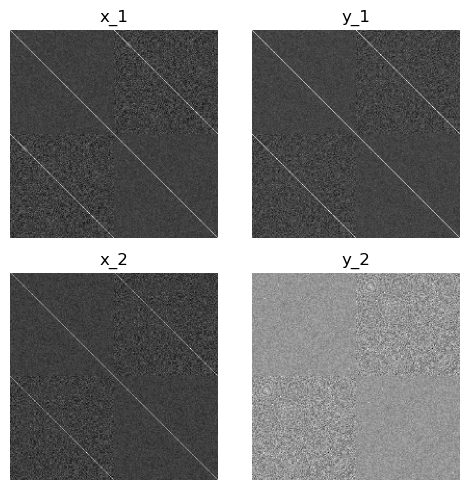

In [22]:
# hacer la mezcla
mezcla = Mezcla_imagenes(señales_originales, A)
señales_y = mezcla.mezclar_señales()
# ver
mezcla.ver_mezcla(figsize = (5, 5))

## Evaluar FCA y OVFCA

In [23]:
# caso con M=1 (que es FCA)

# inicializar FCA
fca = FCA(señales_y)
# calcular covarianzas
fca.compute_covarianzas()

# evaluar la funcion objetivo para varios valores de t
valores_t = np.linspace(0, 2*np.pi ,1000)
funcion_objetivo_t_m1 = np.array([fca.cantidad_maximizar(get_matriz_rotacion(t)) for t in valores_t])

In [24]:
# caso con M=2

# inicializar OVFCA
ovfca = OVFCA(señales_y, esperanza_condicional_F = esperanza_condicional_F2, norma_en_B = frobenius_norm)
# calcular covarianzas
ovfca.compute_covarianzas()

# evaluar la funcion objetivo para varios valores de t
funcion_objetivo_t_m2 = np.array([ovfca.cantidad_maximizar(get_matriz_rotacion(t)) for t in valores_t])

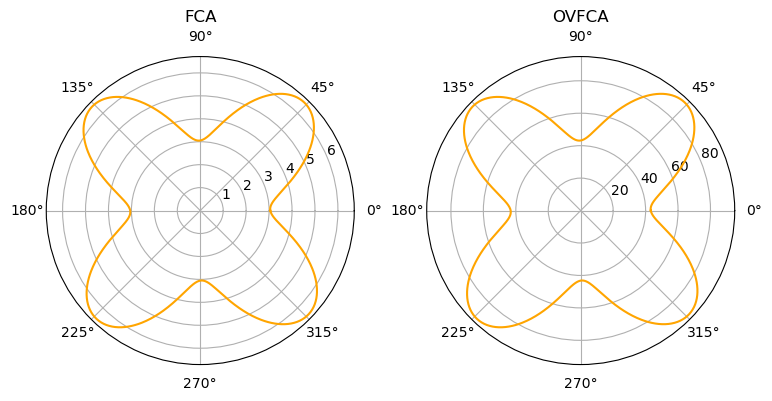

Grados donde se alcanza maximo:
FCA:  [46.126126126126124]
OVFCA:  [46.126126126126124]


In [25]:
# ver juntos
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize = (9, 4))
ax[0].plot(valores_t, funcion_objetivo_t_m1, color='orange')
ax[1].plot(valores_t, funcion_objetivo_t_m2, color='orange')
ax[0].set_title("FCA")
ax[1].set_title("OVFCA")
plt.show()

# imprimir donde se alcanza el mazimo en grados de 0 a 90
t_considerar = valores_t[valores_t <= np.pi/2]
fo_considerar_m1 = funcion_objetivo_t_m1[valores_t <= np.pi/2]
fo_considerar_m2 = funcion_objetivo_t_m2[valores_t <= np.pi/2]
# max de cada caso
max_fo_m1 = max(fo_considerar_m1)
max_fo_m2 = max(fo_considerar_m2)
# donde se alcanza
t_maximo_fo_m1 = [t_considerar[idx] for idx in range(len(t_considerar)) if fo_considerar_m1[idx] == max_fo_m1]
t_maximo_fo_m2 = [t_considerar[idx] for idx in range(len(t_considerar)) if fo_considerar_m2[idx] == max_fo_m2]
print("Grados donde se alcanza maximo:")
print("FCA: ", [180/np.pi * t for t in t_maximo_fo_m1])
print("OVFCA: ", [180/np.pi * t for t in t_maximo_fo_m2])

### Versiones con cumulantes no centrados

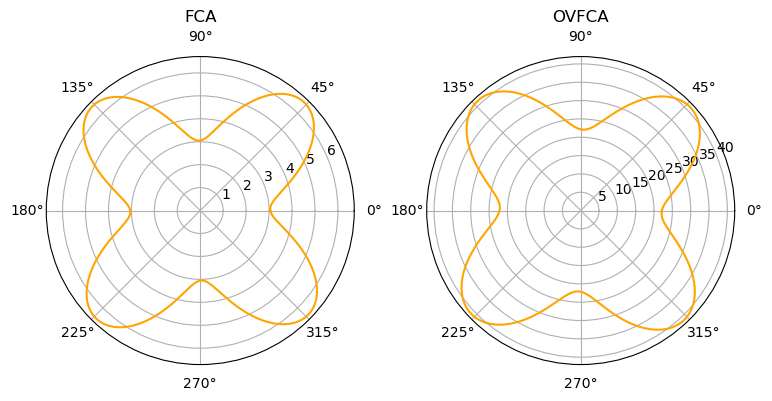

Grados donde se alcanza maximo:
FCA:  [46.126126126126124]
OVFCA:  [43.24324324324324]


In [26]:
# caso con M=1 (que es FCA)

# inicializar FCA
fca_new = FCA_no_centrado(señales_y)
# calcular covarianzas
fca_new.compute_covarianzas()
# evaluar la funcion objetivo para varios valores de t
funcion_objetivo_t_m1 = np.array([fca_new.cantidad_maximizar(get_matriz_rotacion(t)) for t in valores_t])

# caso con M=2

# inicializar OVFCA
ovfca_new = OVFCA_no_centrado(señales_y)
# calcular covarianzas
ovfca_new.compute_covarianzas()
# evaluar la funcion objetivo para varios valores de t
funcion_objetivo_t_m2 = np.array([ovfca_new.cantidad_maximizar(get_matriz_rotacion(t)) for t in valores_t])

# ver juntos
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize = (9, 4))
ax[0].plot(valores_t, funcion_objetivo_t_m1, color='orange')
ax[1].plot(valores_t, funcion_objetivo_t_m2, color='orange')
ax[0].set_title("FCA")
ax[1].set_title("OVFCA")
plt.show()

# imprimir donde se alcanza el mazimo en grados de 0 a 90
t_considerar = valores_t[valores_t <= np.pi/2]
fo_considerar_m1 = funcion_objetivo_t_m1[valores_t <= np.pi/2]
fo_considerar_m2 = funcion_objetivo_t_m2[valores_t <= np.pi/2]
# max de cada caso
max_fo_m1 = max(fo_considerar_m1)
max_fo_m2 = max(fo_considerar_m2)
# donde se alcanza
t_maximo_fo_m1 = [t_considerar[idx] for idx in range(len(t_considerar)) if fo_considerar_m1[idx] == max_fo_m1]
t_maximo_fo_m2 = [t_considerar[idx] for idx in range(len(t_considerar)) if fo_considerar_m2[idx] == max_fo_m2]
print("Grados donde se alcanza maximo:")
print("FCA: ", [180/np.pi * t for t in t_maximo_fo_m1])
print("OVFCA: ", [180/np.pi * t for t in t_maximo_fo_m2])

### Comrpobar que el cumulante 4 se calcule de buena manera

In [27]:
# cumulantes libres (evaluados en la misma variable)
def k_1_free(a):
    return funcional_psi(a)
def k_2_free(a):
    return funcional_psi(a @ a) - funcional_psi(a)**2
def k_3_free(a):
    return funcional_psi(a @ a @ a) - 3*k_1_free(a)*k_2_free(a) - k_1_free(a)**3 
def k_4_free(a):
    part1 = funcional_psi(a @ a @ a @ a) - 4 * k_3_free(a)*k_1_free(a)
    part2 = -2*k_2_free(a)**2 - 6*k_1_free(a)**2 * k_2_free(a) - k_1_free(a)**4
    return part1 + part2

In [28]:
# cumulantes OV (evaluados en distintas variables)
def k_1(a):
    return esperanza_condicional_F2(a)
def k_2(a1, a2):
    return esperanza_condicional_F2(a1 @ a2) - k_1(a1)@k_1(a2)
def k_3(a1, a2, a3):
    part1 = esperanza_condicional_F2(a1 @ a2 @ a3) - k_2(a1, a2) @ k_1(a3)
    part2 = - k_2(a1 @ k_1(a2) , a3) - k_1(a1)@k_2(a2, a3) - k_1(a1)@k_1(a2)@k_1(a3)
    return part1 + part2
def k_4(a1, a2, a3, a4):
    part1 = esperanza_condicional_F2(a1 @ a2 @ a3 @ a4) - k_3(a1, a2, a3) @ k_1(a4)
    part2 = - k_3(a1, a2 @ k_1(a3), a4) - k_2(a1, a2) @ k_2(a3, a4)
    part3 = - k_2(a1, a2) @ k_1(a3) @ k_1(a4) - k_3(a1 @ k_1(a2), a3, a4)
    part4 = - k_2(a1 @ k_1(a2), a3) @ k_1(a4) - k_2(a1 @ k_2(a2, a3), a4)
    part5 = - k_1(a1) @ k_3(a2, a3, a4) - k_1(a1) @ k_2(a2, a3) @ k_1(a4)
    part6 = - k_2(a1 @ k_1(a2) @ k_1(a3), a4) - k_1(a1) @ k_2(a2 @ k_1(a3), a4)
    part7 = - k_1(a1) @ k_1(a2) @ k_2(a3, a4) - k_1(a1) @ k_1(a2) @ k_1(a3) @ k_1(a4)
    return part1 + part2 + part3 + part4 + part5 + part6 + part7
def k4_igual(a):
    return k_4(a, a, a, a)

In [29]:
def print_matriz_resultante(Z):
    """
    Toma una matriz que es: 
    una matriz 2x2 donde cada elemento es una matriz 
    NxN que es un multiplo de la identidad 
    (osea es 2N x 2N)
    se ponen solo los multiplos
    """
    # tomar bloques 
    Z11 = Z[0:N, 0:N]
    Z12 = Z[0:N, N:2 * N]
    Z21 = Z[N:2 * N, 0:N]
    Z22 = Z[N:2 * N, N:2 * N]
    # ver que sea de la forma que se quiere
    assert (Z11 == Z11[0, 0]*np.eye(N)).all()
    assert (Z12 == Z12[0, 0]*np.eye(N)).all()
    assert (Z21 == Z21[0, 0]*np.eye(N)).all()
    assert (Z22 == Z22[0, 0]*np.eye(N)).all()
    # hacer la mini matriz que se quiere
    matriz_imprimir = np.array([[Z11[0, 0], Z12[0, 0]], [Z21[0, 0], Z22[0, 0]]])
    print(matriz_imprimir)

In [30]:
# tomar un elemento ejemplo
W = get_matriz_rotacion(40)
WCY = fca_new.aumentar_matriz(W.T @ fca.C_power_menos_un_medio) @ fca.vector_y
a = fca_new.get_matrices_componentes(WCY, 1)
# otro ejemplo
# a = np.random.randn(2*N, 2*N)

In [31]:
# calcular el cumulante 4 con fca
print(f"Cumualnte 4 con mi metodo: {fca_new.cumulante_4(a)}")
# comprobarlo
print(f"\nCalculado a mano: {k_4_free(a)}")

Cumualnte 4 con mi metodo: 2.9064576718060855

Calculado a mano: 2.9064576718060824


In [32]:
# calcular el cumulante 4 con ovfca
print("Cumualnte 4 con mi metodo:")
result1 = ovfca_new.cumulante_4(a)
print_matriz_resultante(result1)
print(f"Norma: {frobenius_norm(result1)}")
# comprobarlo
print("\nCalculado a mano:")
result2 = k4_igual(a)
print_matriz_resultante(result2)
print(f"Norma: {frobenius_norm(result2)}")

Cumualnte 4 con mi metodo:
[[1.03632429 0.0087215 ]
 [0.0087215  1.03632429]]
Norma: 14.65635761403525

Calculado a mano:
[[1.03632429 0.0087215 ]
 [0.0087215  1.03632429]]
Norma: 14.656357614035214


## Ver distribucion de Eigenvalores

In [33]:
# función auxiliar
def graficar_eigenvalores(matriz, ax, color="skyblue", alpha=1, titulo="Eigenvalores", label="Eigenvalores"):
    """
    Grafica los eigenvalores reales de una matriz en un histograma y devuelve los bins usados.

    Parámetros:
        matriz: numpy.ndarray
            Matriz cuyos eigenvalores serán calculados.
        ax: matplotlib.axes.Axes
            Objeto Axes donde se realizará la gráfica.
        color: str, opcional
            Color de las barras del histograma (por defecto 'skyblue').
        alpha: float, opcional
            Transparencia de las barras del histograma (por defecto 1).
        titulo: str, opcional
            Título de la gráfica (por defecto 'Eigenvalores').
        label: str, opcional
            Etiqueta para la leyenda (por defecto 'Eigenvalores').

    Retorna:
        bins: numpy.ndarray
            Los bordes de los bins utilizados.
    """
    # Calcular eigenvalores
    eigenvalores = np.linalg.eigvals(matriz)
    real_eigenvalues = eigenvalores[np.isclose(eigenvalores.imag, 0)].real

    bins = np.histogram_bin_edges(real_eigenvalues, bins=15)
    # Crear el histograma
    ax.hist(real_eigenvalues, bins=bins, color=color, edgecolor='black', alpha=alpha, label=label)
    ax.set_title(titulo)

In [34]:
# estimar señales originales con FCA y OVFCA
A_hat_fca = fca.separar_señaes()
A_hat_ovfca = ovfca.separar_señaes()

C:\Users\diego\anaconda3\envs\ds\Lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


In [35]:
# por curiosidad, ver C^{-1/2}, pues multuplica a las señales para obtener las originales
print(fca.C_power_menos_un_medio)

[[0.41375265 0.03848113]
 [0.03848113 0.5122443 ]]


In [36]:
# separar en A1_hat A2_hat para cada metodo
# NO NESCERARIAMENTE VAN EN ORDEN, HAY QUE HACERLO MANUAL
# TAMBIEN PUEDE HABER CAMBIOS DE SIGNOS

# fca
A1_hat_fca = -1* A_hat_fca[0]
A2_hat_fca = -1* A_hat_fca[1]

# ovfca
A1_hat_ovfca = -1* A_hat_ovfca[0]
A2_hat_ovfca = -1* A_hat_ovfca[1]

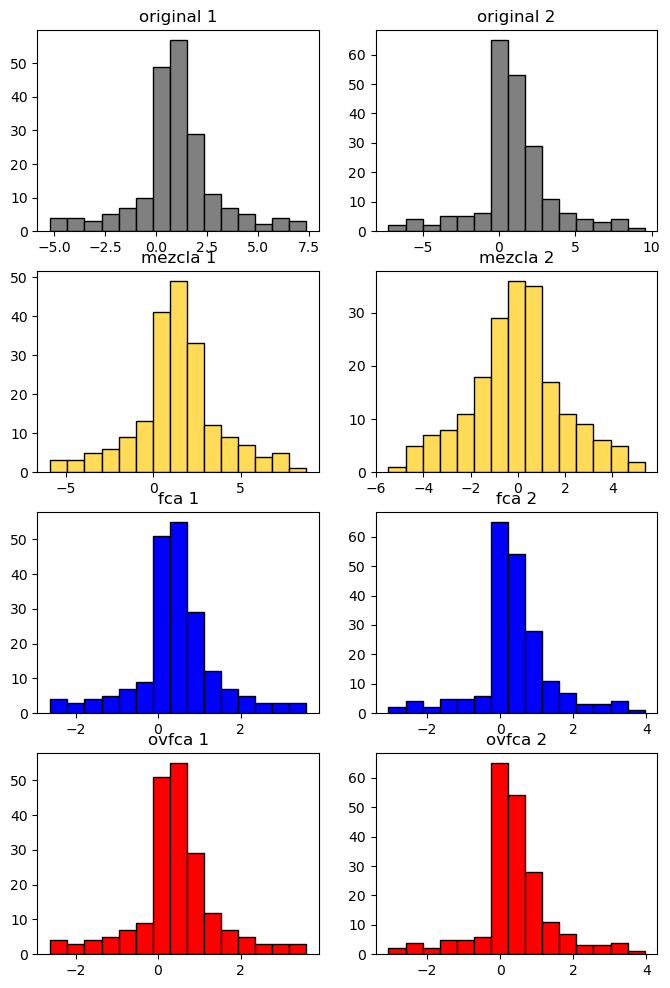

In [37]:
fig, ax = plt.subplots(4, 2, figsize = (8, 12), sharex = False)
# A1 y A2
graficar_eigenvalores(A1, ax = ax[0, 0], color = "gray", titulo = "original 1")
graficar_eigenvalores(A2, ax = ax[0, 1], color = "gray", titulo = "original 2")

# # Y1 y Y2
graficar_eigenvalores(señales_y[0], ax = ax[1, 0], color = "#FFDB58", titulo = "mezcla 1")
graficar_eigenvalores(señales_y[1], ax = ax[1, 1], color = "#FFDB58", titulo = "mezcla 2")

# obtenidas por fca
graficar_eigenvalores(A1_hat_fca, ax = ax[2, 0], color = "blue", titulo = "fca 1")
graficar_eigenvalores(A2_hat_fca, ax = ax[2, 1], color = "blue", titulo = "fca 2")

# obtenidas por fca
graficar_eigenvalores(A1_hat_ovfca, ax = ax[3, 0], color = "red", titulo = "ovfca 1")
graficar_eigenvalores(A2_hat_ovfca, ax = ax[3, 1], color = "red", titulo = "ovfca 2")

plt.show()

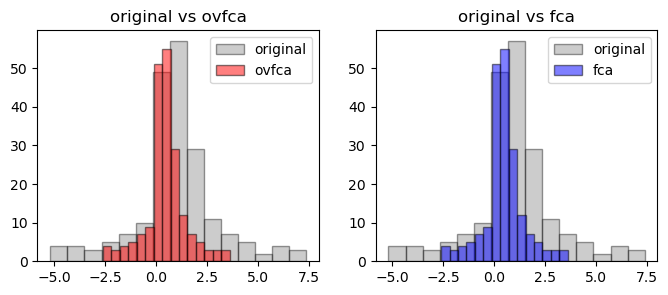

In [38]:
# ver a detenimiento para A1

fig, ax = plt.subplots(1, 2, figsize = (8, 3))

# original vs OVFCA
graficar_eigenvalores(A1, ax = ax[0], color = "gray", titulo = "original vs ovfca", label = "original", alpha = 0.4)
graficar_eigenvalores(A1_hat_ovfca, ax = ax[0], color = "red", titulo = "original vs ovfca", label = "ovfca", alpha = 0.5)
ax[0].legend()

# original vs fca
graficar_eigenvalores(A1, ax = ax[1], color = "gray", titulo = "original vs fca", label = "original", alpha = 0.4)
graficar_eigenvalores(A1_hat_fca, ax = ax[1], color = "blue", titulo = "original vs fca", label = "fca", alpha = 0.5)
ax[1].legend()

plt.show()


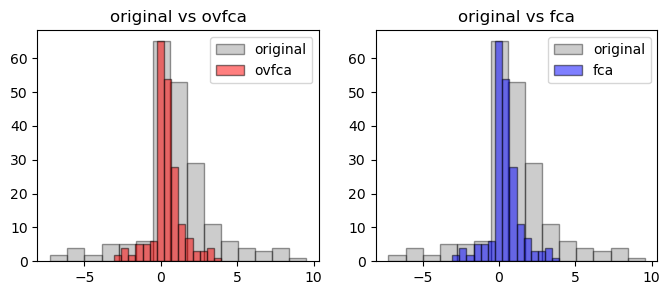

In [39]:
# ver a detenimiento para A2


fig, ax = plt.subplots(1, 2, figsize = (8, 3))

# original vs OVFCA
graficar_eigenvalores(A2, ax = ax[0], color = "gray", titulo = "original vs ovfca", label = "original", alpha = 0.4)
graficar_eigenvalores(A2_hat_ovfca, ax = ax[0], color = "red", titulo = "original vs ovfca", label = "ovfca", alpha = 0.5)
ax[0].legend()

# original vs fca
graficar_eigenvalores(A2, ax = ax[1], color = "gray", titulo = "original vs fca", label = "original", alpha = 0.4)
graficar_eigenvalores(A2_hat_fca, ax = ax[1], color = "blue", titulo = "original vs fca", label = "fca", alpha = 0.5)
ax[1].legend()

plt.show()


### Considerar $C^{\frac{1}{2}} = I$

Eso resuelve el problema del escalamiento

In [40]:
# estimar señales originales con FCA y OVFCA de forma manual

# FCA
aux = fca.W_hat
aux = np.linalg.inv(aux)
aux = fca.aumentar_matriz(aux) @ fca.vector_y
A_hat_fca = [fca.get_matrices_componentes(aux, i) for i in range(fca.s)]

# OVFCA
aux = ovfca.W_hat
aux = np.linalg.inv(aux)
aux = ovfca.aumentar_matriz(aux) @ ovfca.vector_y
A_hat_ovfca = [ovfca.get_matrices_componentes(aux, i) for i in range(ovfca.s)]

In [41]:
# separar en A1_hat A2_hat para cada metodo
# NO NESCERARIAMENTE VAN EN ORDEN, HAY QUE HACERLO MANUAL
# TAMBIEN PUEDE HABER CAMBIOS DE SIGNOS

# fca
A1_hat_fca = -1* A_hat_fca[0]
A2_hat_fca = -1* A_hat_fca[1]

# ovfca
A1_hat_ovfca = -1* A_hat_ovfca[0]
A2_hat_ovfca = -1* A_hat_ovfca[1]

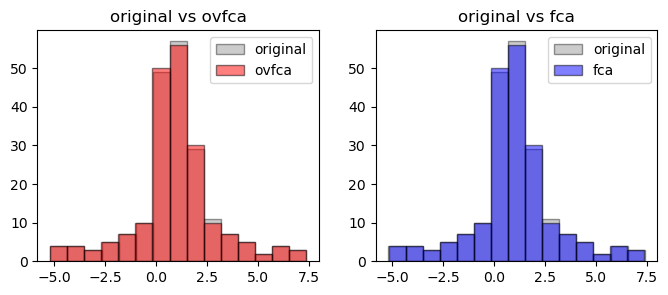

In [42]:
# ver a detenimiento para A1

fig, ax = plt.subplots(1, 2, figsize = (8, 3))

# original vs OVFCA
graficar_eigenvalores(A1, ax = ax[0], color = "gray", titulo = "original vs ovfca", label = "original", alpha = 0.4)
graficar_eigenvalores(A1_hat_ovfca, ax = ax[0], color = "red", titulo = "original vs ovfca", label = "ovfca", alpha = 0.5)
ax[0].legend()

# original vs fca
graficar_eigenvalores(A1, ax = ax[1], color = "gray", titulo = "original vs fca", label = "original", alpha = 0.4)
graficar_eigenvalores(A1_hat_fca, ax = ax[1], color = "blue", titulo = "original vs fca", label = "fca", alpha = 0.5)
ax[1].legend()

plt.show()


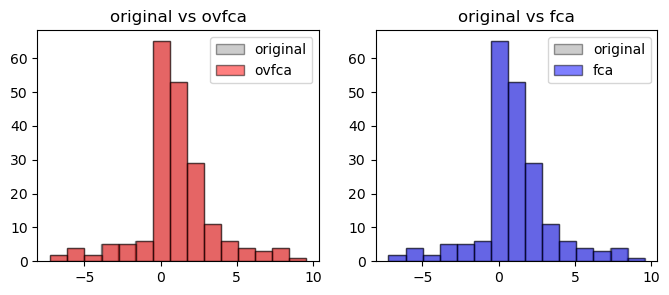

In [43]:
# ver a detenimiento para A2


fig, ax = plt.subplots(1, 2, figsize = (8, 3))

# original vs OVFCA
graficar_eigenvalores(A2, ax = ax[0], color = "gray", titulo = "original vs ovfca", label = "original", alpha = 0.4)
graficar_eigenvalores(A2_hat_ovfca, ax = ax[0], color = "red", titulo = "original vs ovfca", label = "ovfca", alpha = 0.5)
ax[0].legend()

# original vs fca
graficar_eigenvalores(A2, ax = ax[1], color = "gray", titulo = "original vs fca", label = "original", alpha = 0.4)
graficar_eigenvalores(A2_hat_fca, ax = ax[1], color = "blue", titulo = "original vs fca", label = "fca", alpha = 0.5)
ax[1].legend()

plt.show()
